# Applied Data Science Capstone Week 4 #

## London boroughs and Neighbourhoods ##
## Finding a good site for an authentic, exotic, Restaurant ##
### Leveraging FourSquare ###

**By Edward de Ryckman**

https://github.com/eddyholland<br>edward.deryckman@mac.com

For the IBM / Coursera Data Science Capstone <br>
This ipython notebook is in experimental mode. <br>
All errors are mine. File any bug reports to /dev/null

Still - I hope you enjoy it

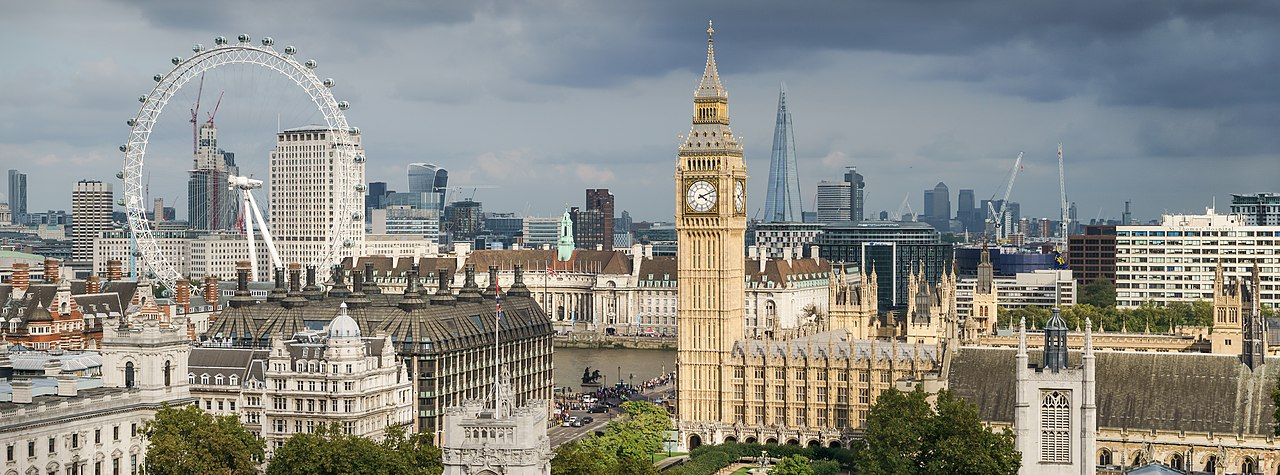

In [51]:
# Setup
#!pip3 install bs4 beautifulsoup4 lxml html5lib pgeocode seaborn xlrd
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import bs4
from bs4 import BeautifulSoup
import urllib.request
import re  # real warriors do it with RegEx
import pgeocode # module to convert an address into latitude and longitude values
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geojson

### Contents ###
1. Problem Statement - what is the Business Goal (business understanding)
2. Data Collection and Data Understanding
3. Data Preparation (data cleansing)
4. Exploratory Data Analysis, and Methodology
5. Evaluation / Results Section
6. Discussion
7. Conclusion

# 1. Problem Statement #

### Business Understanding ###

3 Friends - *Athos, Portos and Aramis* - came to me to seek advice on what would be a good **location** to open an exotic Restaurant in **London**

There are several key factors necessary (but not sufficient) for success in the Restaurant business. Among them are **location**, **supply vs demand** (competition) and **popularity or reputation** (create a buzz). Those are the factors in scope (They are already managing the other factors).

Our goal here is to find, extract, load and cleanse the data, that will help us to make a **recommendation** based on facts (data-driven decision) as to:
* The most promising location(s) in London
* The most promising *cuisines* to promote<br>
For the purposes of this exercise, *London* is defined as the London postcode district (not the greater metropolitan area that includes surrounding counties).

We will be making extensive use of data from **Four Square** supplemented by other open source data like Wikipedia, TFL, ODI, London datastore, etc. 


## 1.b Background ##

### London ###
The London postcodes is an area covering 241 square miles (excluding the surrounding county areas in the wider metropolitan area), broadly organized as 8 *Postcode Areas* and 120 postcodes (post outcodes). The inner (City of London / Westminster) are the central or downtown (CBD) area, known to Transport for London (TFL) az 'Zone 1' and the outer postcodes are residential districts (generally in Zone 3, 4 or 5). See https://en.wikipedia.org/wiki/London and https://en.wikipedia.org/wiki/London_postal_district

London itself is a very important global financial center with a vibrant economy and a large ethnic or immigrant population (including myself) and very well served by a broad and deep range of Restaurants and other leisure and nighlife venues. It is multi-culural and multi-lingual and still an important world city of 8M people (although larger metropolis exist elsewhere). I've lived in London 20+ years.

**Data Sources**
Postcodes we will be scraping from https://en.wikipedia.org/wiki/London_postal_district possibly other Open-source data sources. <br>
For tube (metro) locations we will be scraping from www.tfl.gov.uk


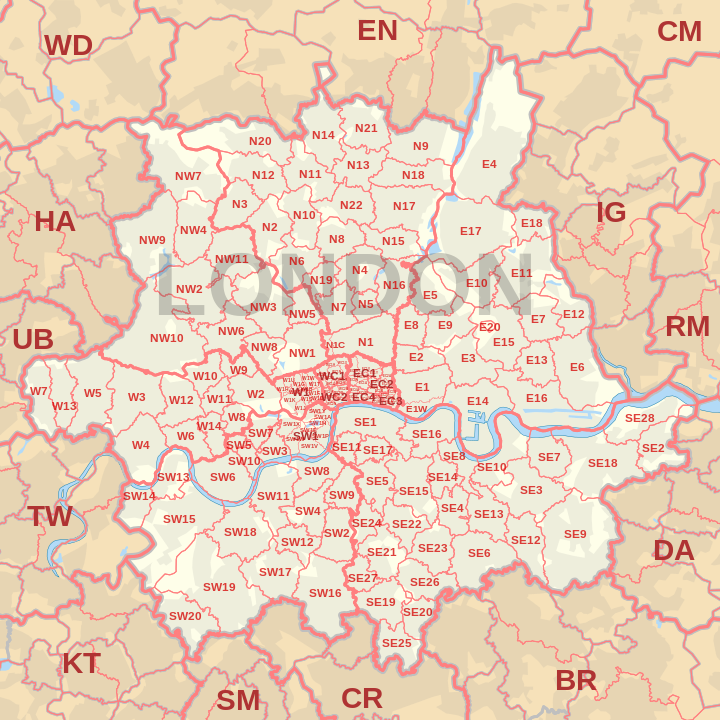<br>
**London post codes**: E, SE, SW, W, N, NW. WC is Westminster and EC is City. Other areas like TW, CR, BR, HA, EN, are outer londer boroughs (not in scope)<br>

### Restaurants ###

**Supply vs. Demand** and Competition. 

Athos, Portos and Aramis each have their own recommendation for the foreign **cuisine** they want to open the Restaurant with - e.g. Cuban or Mexican, Lebanese, Polish. Personally I like all of them.

We will want to look at the:
1) Prevalance of Restaurants in London (and by borough) of different cuisines - because if the market is already saturated in, for example, Indian or French restaurants, we don't want to compete in that space.
2) Likely demand for under-served cuisines using for example population demographics (ethnic origin) or some other indicator of preference.

The goal being to identify a *Demand* that is *Underserved* in a given *Area* i.e. with little head-to-head competition with established Restaurants (of the same / similar cuisine) that aready have a reputation / popularity. If our cusine is *novel* to the area, we have a unique value proposition to attract new diners.

**Location, Location, Location**

When opening a Restaurant (and this is true of many customer-facing businesses) the geographical *Location* is key to success. This is why we will be using geo-location data, both of each London postcode, and of existing (competitor) Restaurants. Bear in mind that in real life it would not be only the centroids of postcodes (or their .geojson bounding boxes) that is of interest here, but the siting of the restaurant - is it on a busy street with lots of footfall, where it can be seen - and also is the frontage attractive (kerb appeal).

We will also try to cross-reference with TFL tube data - is it close to a tube, is there much traffic flow.

**Buzz**

To create a *Buzz* we will have to rely not only on the old-school physical promotion of the Restuaurant but also *Social Media* such as having recommendations on **Four Square** as well as Fessbouc and paying for keywords on Google searches in our London area. Also levearging Twitter, Instagram, etc. Of course if the cook is excellent then word-of-mouth is invaluable.

## 2. Data Collection and Data Understanding ##

London PostCodes: **pdPostCodes**<br>
Location Data (Latitude, Longitude) for London Postcode: **pdPostCodes**<br>
Tube (TFL) Data - both Location (Latitude, Longitue) and also Footfall (entry- and exit flows): **pdTFL_Tube_Flows**<br>
FourSquare Data: **Lon_4sq_venues**<br>
Demographic Data from London Datastore - for Consumer expenditure on Restaurants: **pdConsumerWallet**<br>
GeoJSON bounding files for London Postcodes: **dPostCodeGJSON**

### London PostCodes ###
attribution: thanks to **Wikipedia.org**

In [2]:
# First datasource: London postcode outcodes:
wiki_lon_pc_url = 'https://en.wikipedia.org/wiki/London_postal_district'

page = urllib.request.urlopen(wiki_lon_pc_url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page)

In [127]:
# Inspection time (long - HTML)
#print(soup.prettify())
#long blob of HTML ....

In [3]:
# List the tables, we need to extract specific tables ignoring others
right_table=soup.find_all('table', class_='wikitable')
print("count of tables: {}".format(len(right_table)))
right_table[0]

count of tables: 3


<table class="wikitable">
<tbody><tr>
<th>Postcode area</th>
<th>District<sup class="reference" id="cite_ref-inner_13-1"><a href="#cite_note-inner-13">[13]</a></sup></th>
<th>Postcode districts and district names
</th></tr>
<tr>
<td><a href="/wiki/E_postcode_area" title="E postcode area">E</a></td>
<td><i>Eastern</i></td>
<td><b>E1 Head district</b><br/> E2 Bethnal Green<br/> E3 Bow<br/> E4 Chingford<br/> E5 Clapton<br/> E6 East Ham<br/>E7 Forest Gate<br/> E8 Hackney<br/> E9 Homerton<br/> E10 Leyton<br/> E11 Leytonstone<br/>E12 Manor Park<br/> E13 Plaistow<br/> E14 Poplar<br/> E15 Stratford<br/> E16 Victoria Docks and North Woolwich<br/> E17 Walthamstow<br/> E18 Woodford and South Woodford<br/> E20 Olympic Park
</td></tr>
<tr>
<td><a href="/wiki/EC_postcode_area" title="EC postcode area">EC</a></td>
<td><i>Eastern Central</i></td>
<td><b>EC1 Head district</b><br/>EC2 Bishopsgate<br/>EC3 Fenchurch Street<br/>EC4 Fleet Street
</td></tr>
<tr>
<td><a href="/wiki/N_postcode_area" title="N p

In [4]:
Post_OCodes = pd.read_html(str(right_table[0]))
Post_OCodes[0]

Postcode area     District[13]  \
0             E          Eastern   
1            EC  Eastern Central   
2             N         Northern   

               Postcode districts and district names  
0  E1 Head district E2 Bethnal Green E3 Bow E4 Ch...  
1  EC1 Head districtEC2 BishopsgateEC3 Fenchurch ...  
2  N1 Head district N2 East Finchley N3 Finchley ...

### Data Wrangling ###
This data is not exactly in a good shape for us (there is **not** 1 table row per postcode, there is just list of postcodes)<br>
So we will have to iterate through the table rows and get all the distinct lines of text for the postcodes.

In [5]:
## Parse our soup "right_table" for the list of Postcodes:
postcodes = []

for i in range(0, len(right_table)):   # there are several tables (3) in this wiki article
    
    # for each <table row> :
    for row in right_table[i].findAll('tr'):
        
        # list of <table data> cells
        cells=row.findAll('td')
        
        # matching cells:
        if len(cells)>=2:
            # here we split by html \n tag
            # lcodes is a list of codes
            lcodes = str(cells[-1]).split('<br/>')
            
            # here we cleanup html tags on our string: first list item and last list item
            clean = re.compile('<.*?>')
            lcodes[0] = re.sub(clean, '', lcodes[0])
            lcodes[-1] = re.sub(clean, '', lcodes[-1])
            
            # tokenize (split)
            for item in lcodes:
                postcodes.append(re.split('(\D+\d+)',item))
                ##print(re.split('(\D+\d+)',item))

print("len: {}".format(len(postcodes)))      

len: 120


In [6]:
# structur of postcodes[]
postcodes[0:5]
# postcodes[] is a list of tuples: null, postcode, label - not great. Needs cleanup

[['', 'E1', ' Head district'],
 ['', ' E2', ' Bethnal Green'],
 ['', ' E3', ' Bow'],
 ['', ' E4', ' Chingford'],
 ['', ' E5', ' Clapton']]

In [7]:
# We have to tidy it a bit further (strip spaces) and cast it into a Pandas DataFrame:
# dataFrame
pdPostCodes = pd.DataFrame(columns=['Outcode','Neighbourhood'])

for litem in postcodes:
    code = litem[1].strip(' \t\n\r')
    label = litem[2].strip(' \t\n\r')
    # yeah we can ignore list-item[0] it is null
    
    row = {'Outcode':code, 'Neighbourhood': label}
    pdPostCodes = pdPostCodes.append(row, ignore_index=True)
    
pdPostCodes[-5:]

Outcode    Neighbourhood
115     W12   Shepherds Bush
116     W13      West Ealing
117     W14  West Kensington
118     WC1    Head district
119     WC2           Strand

### Win ! ###
Now PostCode data is clean and in a pandas DataFrame.<br>
Next tasks:<br>
1. Append the geospatial Latitue, Longitude of each postcode (the 'centroid') - *Thanks and credits to pgeocode library*
2. Get a list of TFL tube stations and their locations (Lat, Long)
3. Optionally we may enrich with further datasource (like Crime statistics, whatever)

In [8]:
nomi = pgeocode.Nominatim('gb')

df = nomi.query_postal_code('SW6')
print('TestSW6 coordinates : {} : {}'.format(df['latitude'], df['longitude']))

TestSW6 coordinates : 51.4803 : -0.1993


In [9]:
# Exend our dataframe (make space)
pdPostCodes[['latitude', 'longitude']] = pd.DataFrame([[np.nan, np.nan]])

# Populate our dataframe with the 2 extra columns
for row in pdPostCodes.itertuples():  
    df = nomi.query_postal_code(row[1])

    pdPostCodes.at[row[0], 'latitude'] = df['latitude']
    pdPostCodes.at[row[0], 'longitude'] = df['longitude']
    
pdPostCodes.set_index('Outcode', inplace = True)

pdPostCodes[-5:]

Neighbourhood  latitude  longitude
Outcode                                      
W12       Shepherds Bush   51.5050  -0.221100
W13          West Ealing   51.5122  -0.311625
W14      West Kensington   51.5019  -0.217980
WC1        Head district   51.5333  -0.122300
WC2               Strand   51.5175  -0.123382

In [10]:
pdPostCodes[pdPostCodes.isna().any(axis=1)]

Neighbourhood  latitude  longitude
Outcode                                     
N9       Lower Edmonton       NaN        NaN

In [11]:
# Fix missing value for N9 
pdPostCodes.at['N9','latitude'] = 51.6285
pdPostCodes.at['N9','longitude'] = -0.0580

#### Yay! win ####

### Tube Data: TFL ###
Now we try to get TFL Tube stations and locations

In [224]:
# This TFL data was requested under Freedom of Information regulations and posted here in the open domain in 'What do they Know'
pdTFL_tubes = pd.read_csv('https://www.whatdotheyknow.com/request/512947/response/1238210/attach/3/Stations%2020180921.csv.txt?cookie_passthrough=1')

print('Data downloaded!')
print('len : {}'.format(len(pdTFL_tubes)))
pdTFL_tubes.head()

Data downloaded!
len : 479


FID  OBJECTID           NAME  EASTING  NORTHING             LINES  \
0    0        78         Temple   530959    180803  District, Circle   
1    1        79    Blackfriars   531694    180893  District, Circle   
2    2        80  Mansion House   532354    180932  District, Circle   
3    3        81  Cannon Street   532611    180900  District, Circle   
4    4        82       Monument   532912    180824  District, Circle   

              NETWORK  Zone         x          y  
0  London Underground     1 -0.112644  51.510474  
1  London Underground     1 -0.102020  51.511114  
2  London Underground     1 -0.092495  51.511306  
3  London Underground     1 -0.088801  51.510963  
4  London Underground     1 -0.084502  51.510209

In [225]:
pdTFL_tubes.drop(['OBJECTID','EASTING','NORTHING'], axis = 1, inplace=True) # don't need these (Easting is OS equivalent of x)
pdTFL_tubes.rename(columns = {'x':'longitude', 'y':'latitude'}, inplace = True)  # we do need these : y is latitude

pdTFL_tubes = pdTFL_tubes.dropna()  # drop the 200 or so observations that are not part of a London Underground line (i.e. Rail, Overground etc)
print(pdTFL_tubes.shape)
pdTFL_tubes[0:5]

(271, 7)


FID           NAME             LINES             NETWORK  Zone  longitude  \
0    0         Temple  District, Circle  London Underground     1  -0.112644   
1    1    Blackfriars  District, Circle  London Underground     1  -0.102020   
2    2  Mansion House  District, Circle  London Underground     1  -0.092495   
3    3  Cannon Street  District, Circle  London Underground     1  -0.088801   
4    4       Monument  District, Circle  London Underground     1  -0.084502   

    latitude  
0  51.510474  
1  51.511114  
2  51.511306  
3  51.510963  
4  51.510209

### FourSquare Data ###
**Venues**

#### Define Foursquare Credentials and Version


In [18]:
CLIENT_ID = 'AB5AMGTIZ3MP3WS1EZPNW2XYO3G4ACCWZOZEHUWK4SSRXJH4' # my Foursquare ID
CLIENT_SECRET = 'U2A4KZRTK4D5H2H42KKDYILDFERZLHOTC4AWWNR4RC5UPSSS' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 250 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

My credentails:
CLIENT_ID: AB5AMGTIZ3MP3WS1EZPNW2XYO3G4ACCWZOZEHUWK4SSRXJH4


Function that will repeat calls on FourSquare API for venues matching our query and append to our dataFrame

In [20]:
def getNearbyVenues(neighbourhoods, codes, latitudes, longitudes, radius):

    query='Food'
    venues_list=[]
    for neighbourhood, pcode, lat, lng, radius in zip(neighbourhoods, codes, latitudes, longitudes, radius):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
        #url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,       CLIENT_SECRET,   
            VERSION, 
            lat,     lng,             
            query,
            radius,
            LIMIT)
        #print(url)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode,
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('postalCode', code),
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Outcode',
                  'Neighbourhood', 
                  'latitude', 
                  'longitude', 
                  'Venue_id',
                  'Venue', 
                  'Venue_latitude', 
                  'Venue_longitude', 
                  'Venue_Postcode',
                  'Venue_category']
    
    return(nearby_venues)

In [24]:
# Enrich with this dataset - very roughly, how large the radius of the postcode is (Sml, Med, Large)
pdPostCodesizes = pd.read_csv('postcodedatasize.csv')
pdPostCodesizes.drop(['Neighbourhood'], axis = 1, inplace=True)

# Inner join to add new column to my dataframe:
pdPostCodes = pd.merge(pdPostCodes, pdPostCodesizes, how='inner', on='Outcode')

In [25]:
pdPostCodes.tail()

Outcode    Neighbourhood  latitude  longitude  Radius
115     W12   Shepherds Bush   51.5050  -0.221100    1500
116     W13      West Ealing   51.5122  -0.311625    1500
117     W14  West Kensington   51.5019  -0.217980    1500
118     WC1    Head district   51.5333  -0.122300     600
119     WC2           Strand   51.5175  -0.123382     600

In [73]:
Lon_4sq_venues = getNearbyVenues(neighbourhoods= pdPostCodes['Neighbourhood'],
                             codes= pdPostCodes.index.values,
                             latitudes= pdPostCodes['latitude'],
                             longitudes= pdPostCodes['longitude'],
                             radius=pdPostCodes['Radius'])
print(Lon_4sq_venues.shape)

(6124, 10)


In [27]:
Lon_4sq_venues.head()

Outcode  Neighbourhood  latitude  longitude                  Venue_id  \
0        0  Head district      51.5  -0.061773  4e1efe33b61cc42aee3e38c1   
1        0  Head district      51.5  -0.061773  4e04d8b97d8b58ba0dcd50fc   
2        0  Head district      51.5  -0.061773  4bc07776b492d13a5f42a460   
3        0  Head district      51.5  -0.061773  4f7459abe4b0dd96b6c8146a   
4        0  Head district      51.5  -0.061773  4ac518e3f964a520c3aa20e3   

                 Venue  Venue_latitude  Venue_longitude Venue_Postcode  \
0     Cantinho da Maya       51.498767        -0.058847            WC2   
1              Smith's       51.504390        -0.066523        E1W 1NJ   
2     Turk's Head Cafe       51.504232        -0.061209         E1 W 2   
3  Little Bread Pedlar       51.495883        -0.069083            WC2   
4       Blueprint Cafe       51.503010        -0.071838        SE1 2YD   

         Venue_category  
0  Brazilian Restaurant  
1    Seafood Restaurant  
2        Breakfast Spot  
3                Bakery  
4    English Restaurant

Let's check out our dataframe of **Venues** and if data quality is good<br>
Notice for later the so-called *'Head District'*

In [28]:
Lon_4sq_venues.groupby('Neighbourhood').count().sort_values('Venue', ascending=False).head(10)

Outcode  latitude  longitude  Venue_id  Venue  \
Neighbourhood                                                     
Head district         763       763        763       763    763   
South Kensington      100       100        100       100    100   
Fleet Street          100       100        100       100    100   
Stoke Newington       100       100        100       100    100   
Strand                100       100        100       100    100   
Chiswick              100       100        100       100    100   
West Kensington       100       100        100       100    100   
Hammersmith           100       100        100       100    100   
Shepherds Bush        100       100        100       100    100   
Holloway              100       100        100       100    100   

                  Venue_latitude  Venue_longitude  Venue_Postcode  \
Neighbourhood                                                       
Head district                763              763             763   
South Kensington             100              100             100   
Fleet Street                 100              100             100   
Stoke Newington              100              100             100   
Strand                       100              100             100   
Chiswick                     100              100             100   
West Kensington              100              100             100   
Hammersmith                  100              100             100   
Shepherds Bush               100              100             100   
Holloway                     100              100             100   

                  Venue_category  
Neighbourhood                     
Head district                763  
South Kensington             100  
Fleet Street                 100  
Stoke Newington              100  
Strand                       100  
Chiswick                     100  
West Kensington              100  
Hammersmith                  100  
Shepherds Bush               100  
Holloway                     100

In [29]:
df_categories = Lon_4sq_venues.groupby('Venue_category').count().sort_values('Venue', ascending=False)
print("len: {}".format(len(df_categories)))
print("top ten categories:")
df_categories[0:10]

len: 126
top ten categories:


Outcode  Neighbourhood  latitude  longitude  Venue_id  \
Venue_category                                                                
Café                      996            996       996        996       996   
Italian Restaurant        393            393       393        393       393   
Pizza Place               347            347       347        347       347   
Bakery                    310            310       310        310       310   
Indian Restaurant         287            287       287        287       287   
Fast Food Restaurant      229            229       229        229       229   
Restaurant                206            206       206        206       206   
Sandwich Place            202            202       202        202       202   
Chinese Restaurant        193            193       193        193       193   
Turkish Restaurant        161            161       161        161       161   

                      Venue  Venue_latitude  Venue_longitude  Venue_Postcode  
Venue_category                                                                
Café                    996             996              996             996  
Italian Restaurant      393             393              393             393  
Pizza Place             347             347              347             347  
Bakery                  310             310              310             310  
Indian Restaurant       287             287              287             287  
Fast Food Restaurant    229             229              229             229  
Restaurant              206             206              206             206  
Sandwich Place          202             202              202             202  
Chinese Restaurant      193             193              193             193  
Turkish Restaurant      161             161              161             161

### GeoJSON bounding polygons for London postcodes ###
Let's get some .geojson bounding polygons for all our postcodes<br>
This data was forked from https://github.com/missinglink/uk-postcode-polygons all credit to him.<br>
We pulled 7 .geojson files for London postcodes into this repo. 

In [52]:
featurelist = []

PostCodeAreas = ['SE','SW','W','NW','N','E','EC','WC']
for area in PostCodeAreas:
    with open(area + '.geojson') as f:
        data = json.load(f)
        d1 = data['features']
        for postcode in d1:
            #print(postcode['properties']['name'])
            featurelist.append(postcode)

dPostCodeGJSON = {'type': 'FeatureCollection', 'features' : featurelist}

In [53]:
dPostCodeGJSON.keys()

dict_keys(['type', 'features'])

In [55]:
dPostCodeGJSON['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [56]:
dPostCodeGJSON['features'][0]['properties']

{'name': 'SE1',
 'styleUrl': '#SE',
 'styleHash': '-1b95e2c4',
 'description': 'SE1 postcode district',
 'fill': '#00ffff',
 'fill-opacity': 0.4980392156862745}

I am hoping to use it later in a Folium map, perhaps a Chloropleth. <br>
*geometry* is a set of coordinates for polygon (quite a long list)

### LUL Tube Flows data ###
This data was pulled from **London DataStore** here:<br>
https://data.london.gov.uk/dataset/london-underground-performance-reports <br>
and is TFL open source data. I only have flows to 2017<br>
We have the average daily Entry- and Exit- flows on weekdays, Saturday, Sunday, and total for the year. Per Station <br>

In [227]:
TFL_Tube_Flows = "https://data.london.gov.uk/download/london-underground-performance-reports/b6ab04fc-9062-4291-b514-7fa218073b4c/multi-year-station-entry-and-exit-figures.xls"

urllib.request.urlretrieve(TFL_Tube_Flows, "TFL_multi-year-station-entry-and-exit-figures.xls")  # For Python 3

('TFL_multi-year-station-entry-and-exit-figures.xls',
 <http.client.HTTPMessage at 0x1284cbc70>)

In [228]:
pdTFL_Tube_Flows = pd.read_excel('TFL_multi-year-station-entry-and-exit-figures.xls', 
                                 sheet_name = 1, # Latest year only please (it's 2017 Entry & Exit)
                                 usecols = "A:C,E:K", # columns we care: index, category, years 2021-2030
                                 skiprows = 6)

In [62]:
pdTFL_Tube_Flows.head(5)

nlc       Station         Borough  Weekday  Saturday   Sunday  Weekday.1  \
0  500.0    Acton Town          Ealing   9531.0    6716.0   4744.0     9382.0   
1  502.0       Aldgate  City of London  15080.0    4397.0   3261.0    16023.0   
2  503.0  Aldgate East   Tower Hamlets  22327.0   16166.0  13323.0    21071.0   
3  505.0      Alperton           Brent   4495.0    3279.0   2345.0     5081.0   
4  506.0      Amersham        Chiltern   3848.0    1876.0   1232.0     4025.0   

   Saturday.1  Sunday.1    million  
0      6617.0    4785.0   6.040516  
1      5909.0    4230.0   8.846940  
2     13893.0   11347.0  13.998292  
3      3392.0    2445.0   3.052230  
4      1797.0    1121.0   2.321692

In [229]:
pdTFL_Tube_Flows.rename(columns = {'Weekday.1':'Weekday_ex', 'Saturday.1':'Saturday_ex', 'Sunday.1':'Sunday_ex'}, inplace = True)  # we do need these : y is latitude
pdTFL_Tube_Flows.dropna(inplace = True)
print(pdTFL_Tube_Flows.shape)
pdTFL_Tube_Flows.tail(5)

(268, 10)


nlc         Station                 Borough  Weekday  Saturday  \
263  768.0  Wimbledon Park                  Merton   3583.0    2648.0   
264  770.0      Wood Green                Haringey  20042.0   15815.0   
265  599.0       Wood Lane  Hammersmith and Fulham   6242.0    4516.0   
266  769.0        Woodford               Redbridge   9442.0    6937.0   
267  771.0   Woodside Park                  Barnet   5311.0    2997.0   

      Sunday  Weekday_ex  Saturday_ex  Sunday_ex    million  
263   1605.0      3301.0       2235.0     1600.0   2.184663  
264  11793.0     18949.0      16020.0    11415.0  12.889415  
265   2267.0      6631.0       4294.0     2494.0   3.995888  
266   4140.0      9537.0       6301.0     4142.0   5.978701  
267   2246.0      6089.0       3760.0     2967.0   3.543131

### Consumer Expenditure Data ###
This data is sourced from **London DataStore** here:<br>
https://data.london.gov.uk/dataset/london-consumer-expenditure-estimates-2011-2036<br>
And I chose it because it has a breakdown of Consumer spending on **Restaurants and Caffees** and a 10-year forward looking projection of those values. Per Postcode.

In [64]:
LonConsumerExpendEst_Data = "https://data.london.gov.uk/download/london-consumer-expenditure-estimates-2011-2036/322f914f-5ca0-4ae2-8d25-fc8443f9e6e8/aggregated-postal-base-greater-london.xls"

urllib.request.urlretrieve(LonConsumerExpendEst_Data, "LonConsumerExpendEst_Data.xls")  # For Python 3


('LonConsumerExpendEst_Data.xls', <http.client.HTTPMessage at 0x1284cdb20>)

In [65]:
dictConsumerWallet = pd.read_excel('LonConsumerExpendEst_Data.xls', 
                                 sheet_name = [1,3,4,5,6,7,8,9,10,11,12,13,17,18,19,21,22,23,24,25,26,27,29,30,31,32], # Boroughs we care about (with inner london postcodes) - by inspection
                                 usecols = "A,B,Y:AH", # columns we care: index, category, years 2021-2030
                                 skiprows = 3)

In [67]:
dictConsumerWallet[1][dictConsumerWallet[1]['Sector'] == 'Restaurants and Caffees'].head(5)

Postal Code                   Sector      2021      2022      2023  \
277        EN48  Restaurants and Caffees  5.645637  5.708080  5.762569   
278        EN49  Restaurants and Caffees  4.692449  4.746617  4.795827   
279        EN51  Restaurants and Caffees  4.546466  4.601580  4.651896   
280        EN52  Restaurants and Caffees  5.569179  5.622243  5.669985   
281        EN53  Restaurants and Caffees  1.703791  1.722102  1.738320   

         2024      2025      2026      2027      2028      2029      2030  
277  5.829934  5.882623  5.945093  6.005013  6.060958  6.124812  6.181022  
278  4.852596  4.899843  4.953323  5.006356  5.051413  5.106980  5.155471  
279  4.708584  4.756317  4.809773  4.863575  4.907531  4.963260  5.011699  
280  5.731596  5.779302  5.837528  5.894163  5.944492  6.004142  6.055296  
281  1.758891  1.774296  1.793482  1.812628  1.828256  1.847635  1.863876

In [66]:
pdConsumerWallet = pd.DataFrame(columns = dictConsumerWallet[1].columns )

## 3. Data Preparation / Cleansing ##


### Interim Findings ###
1. We have 6,100+ venues in London of type "Food"
2. I fail to find (in FourSquare) any venues for a few postcodes
3. There are duplicate Venues in FourSquare dataframe because the search returns matches within a given (say 1000m) radius, and these circles overlap in central london - leading to double-counting.
4. I have error in the Key value "Head District" which needs correcting in **pdPostCodes**. There are **10** head districts and they *should* each have distinct neighbourhood names, and anyway their index (Outcode) was different. We can correct for this (data cleaning)
5. The ConsumerWallet dataset, is at 1 level of granularity too deep and will need to be aggregated up to Post Outcodes.

In [81]:
# Strip the venues which are duplicated (appear in multiple PostCode searches) - keep only the one that matches the Postcode
for row_tuple in Lon_4sq_venues.itertuples():
    venue_outcode = row_tuple.Venue_Postcode.strip(' \t\n\r')
    venue_outcode = re.split('(\D+\d+)', venue_outcode)
    #print(row_tuple)
    try:

        if venue_outcode[1] != row_tuple.Outcode:
            #print("dropping: {}, {}, {}, {}".format(row_tuple.Outcode, row_tuple.Venue_Postcode, venue_outcode, row_tuple.Venue))
            Lon_4sq_venues.drop(row_tuple.Index, inplace = True)
        else:
            #keep
            pass

    except IndexError:
        # not nice but we drop these bad data anyway.
        Lon_4sq_venues.drop(row_tuple.Index, inplace = True)
    


In [82]:
Lon_4sq_venues.shape

(2904, 10)

But only 2,900 distinct venues though....

#### Clean the PostCode data ####

In [30]:
pdPostCodes[pdPostCodes['Neighbourhood']=='Head district']

Outcode  Neighbourhood  latitude  longitude  Radius
0        E1  Head district   51.5000  -0.061773     900
19      EC1  Head district   51.5262  -0.105518     600
23       N1  Head district   51.5407  -0.094400    1000
45      NW1  Head district   51.5333  -0.147182    1500
56      SE1  Head district   51.5025  -0.093038    1500
84      SW1  Head district   51.4890  -0.141792     600
94     SW11  Head district   51.4747  -0.161933     600
104      W1  Head district   51.5144  -0.098643     600
105      W2  Head district   51.5112  -0.188645    1000
118     WC1  Head district   51.5333  -0.122300     600

In [42]:
pdPostCodes.set_index('Outcode', inplace=True)

In [43]:
# corrections (can't have 10 head districts, give them more distinctive names)
pdPostCodes.at['E1','Neighbourhood'] = 'E1 Head - Whitechapel'
pdPostCodes.at['EC1','Neighbourhood'] = 'EC1 City - Clerkenwell, Finsbury'
pdPostCodes.at['N1','Neighbourhood'] = 'N1 Head - Kings Cross, Islington, Hoxton'
pdPostCodes.at['NW1','Neighbourhood'] = 'NW1 - Marylebone, Regents Park, Baker Street'
pdPostCodes.at['SE1','Neighbourhood'] = 'SE1 Head - South Bank, Soutwark'
pdPostCodes.at['SW1','Neighbourhood'] = 'SW1 - Whitehall, Parliament, Buckingham Palace'
pdPostCodes.at['SW11','Neighbourhood'] = 'SW11 - Battersea' 
pdPostCodes.at['W1','Neighbourhood'] = 'W1 Head - Westminster, Soho, Mayfair' 
pdPostCodes.at['W2','Neighbourhood'] = 'W2 - Paddington, Hyde Park'
pdPostCodes.at['WC1','Neighbourhood'] = 'WC1 Westminster - Bloomsbury, High Holborn'
pdPostCodes.at['WC2','Neighbourhood'] = 'WC2 City of Westminster, Strand'

In [57]:
pdPostCodes[pdPostCodes['Neighbourhood']=='Head district']

Empty DataFrame
Columns: [Neighbourhood, latitude, longitude, Radius]
Index: []

In [50]:
pdPostCodes.shape

(120, 4)

## 4. Exploratory Data Analysis and Graphs, Maps ##

#### Lon_4sq_venues ####
Which Postcodes have the most "Food" venues? <br>
Which Venue Categories are the most common?

In [92]:
Lon_4sq_venues.describe(include = 'all')

Outcode                             Neighbourhood     latitude  \
count     2904                                      2904  2904.000000   
unique     113                                       113          NaN   
top         N1  N1 Head - Kings Cross, Islington, Hoxton          NaN   
freq        87                                        87          NaN   
mean       NaN                                       NaN    51.515192   
std        NaN                                       NaN     0.050769   
min        NaN                                       NaN    51.399400   
25%        NaN                                       NaN    51.481200   
50%        NaN                                       NaN    51.511200   
75%        NaN                                       NaN    51.547100   
max        NaN                                       NaN    51.635700   

          longitude                  Venue_id   Venue  Venue_latitude  \
count   2904.000000                      2904    2904     2904.000000   
unique          NaN                      2904    2335             NaN   
top             NaN  55e0c771498e34b61249f6d8  Greggs             NaN   
freq            NaN                         1      41             NaN   
mean      -0.121674                       NaN     NaN       51.515155   
std        0.084287                       NaN     NaN        0.050658   
min       -0.335900                       NaN     NaN       51.386742   
25%       -0.188645                       NaN     NaN       51.483890   
50%       -0.116700                       NaN     NaN       51.510047   
75%       -0.062900                       NaN     NaN       51.547406   
max        0.104500                       NaN     NaN       51.649104   

        Venue_longitude Venue_Postcode Venue_category  
count       2904.000000           2904           2904  
unique              NaN           1997            108  
top                 NaN        SE5 8TR           Café  
freq                NaN             10            443  
mean          -0.122613            NaN            NaN  
std            0.085026            NaN            NaN  
min           -0.339348            NaN            NaN  
25%           -0.188229            NaN            NaN  
50%           -0.121872            NaN            NaN  
75%           -0.067550            NaN            NaN  
max            0.105200            NaN            NaN

<AxesSubplot:ylabel='Frequency'>

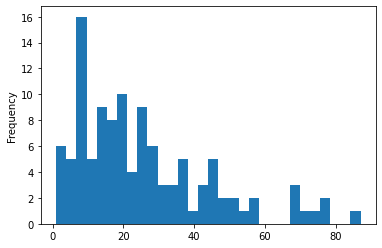

In [107]:
Lon_4sq_venues.Outcode.value_counts().plot.hist(bins = 30)
# frequency distribution, of the value counts.

Postcodes with most venues? <br>
Postcodes with least venues?

In [111]:
Lon_4sq_venues.groupby('Neighbourhood').count().sort_values('Venue', ascending=False).head(10)

Outcode  latitude  longitude  \
Neighbourhood                                                                  
N1 Head - Kings Cross, Islington, Hoxton             87        87         87   
Poplar                                               78        78         78   
South Kensington                                     78        78         78   
EC1 City - Clerkenwell, Finsbury                     75        75         75   
Stoke Newington                                      70        70         70   
Chiswick                                             69        69         69   
SE1 Head - South Bank, Soutwark                      69        69         69   
NW1 - Marylebone, Regents Park, Baker Street         67        67         67   
SW1 - Whitehall, Parliament, Buckingham Palace       58        58         58   
W2 - Paddington, Hyde Park                           58        58         58   

                                                Venue_id  Venue  \
Neighbourhood                                                     
N1 Head - Kings Cross, Islington, Hoxton              87     87   
Poplar                                                78     78   
South Kensington                                      78     78   
EC1 City - Clerkenwell, Finsbury                      75     75   
Stoke Newington                                       70     70   
Chiswick                                              69     69   
SE1 Head - South Bank, Soutwark                       69     69   
NW1 - Marylebone, Regents Park, Baker Street          67     67   
SW1 - Whitehall, Parliament, Buckingham Palace        58     58   
W2 - Paddington, Hyde Park                            58     58   

                                                Venue_latitude  \
Neighbourhood                                                    
N1 Head - Kings Cross, Islington, Hoxton                    87   
Poplar                                                      78   
South Kensington                                            78   
EC1 City - Clerkenwell, Finsbury                            75   
Stoke Newington                                             70   
Chiswick                                                    69   
SE1 Head - South Bank, Soutwark                             69   
NW1 - Marylebone, Regents Park, Baker Street                67   
SW1 - Whitehall, Parliament, Buckingham Palace              58   
W2 - Paddington, Hyde Park                                  58   

                                                Venue_longitude  \
Neighbourhood                                                     
N1 Head - Kings Cross, Islington, Hoxton                     87   
Poplar                                                       78   
South Kensington                                             78   
EC1 City - Clerkenwell, Finsbury                             75   
Stoke Newington                                              70   
Chiswick                                                     69   
SE1 Head - South Bank, Soutwark                              69   
NW1 - Marylebone, Regents Park, Baker Street                 67   
SW1 - Whitehall, Parliament, Buckingham Palace               58   
W2 - Paddington, Hyde Park                                   58   

                                                Venue_Postcode  Venue_category  
Neighbourhood                                                                   
N1 Head - Kings Cross, Islington, Hoxton                    87              87  
Poplar                                                      78              78  
South Kensington                                            78              78  
EC1 City - Clerkenwell, Finsbury                            75              75  
Stoke Newington                                             70              70  
Chiswick                                                    69              69  
SE1 Head - South Bank, Soutwark     

In [112]:
Lon_4sq_venues.groupby('Neighbourhood').count().sort_values('Venue', ascending=False).tail(10)

Outcode  latitude  longitude  Venue_id  Venue  Venue_latitude  \
Neighbourhood                                                                  
Stockwell            6         6          6         6      6               6   
South Norwood        6         6          6         6      6               6   
Hendon               6         6          6         6      6               6   
New Southgate        5         5          5         5      5               5   
Thamesmead           3         3          3         3      3               3   
East Ham             3         3          3         3      3               3   
Plaistow             2         2          2         2      2               2   
Brixton              2         2          2         2      2               2   
Holloway             2         2          2         2      2               2   
Walworth             1         1          1         1      1               1   

               Venue_longitude  Venue_Postcode  Venue_category  
Neighbourhood                                                   
Stockwell                    6               6               6  
South Norwood                6               6               6  
Hendon                       6               6               6  
New Southgate                5               5               5  
Thamesmead                   3               3               3  
East Ham                     3               3               3  
Plaistow                     2               2               2  
Brixton                      2               2               2  
Holloway                     2               2               2  
Walworth                     1               1               1

Venue Categories which are most frequent?<br>
Venue Categories which are least frequent?

<AxesSubplot:ylabel='Frequency'>

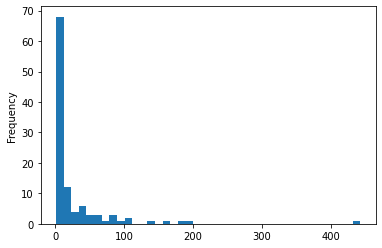

In [117]:
Lon_4sq_venues.Venue_category.value_counts().plot.hist(bins = 40)

In [113]:
Lon_4sq_venues.groupby('Venue_category').count().sort_values('Venue', ascending=False).head(10)

Outcode  Neighbourhood  latitude  longitude  Venue_id  \
Venue_category                                                                
Café                      443            443       443        443       443   
Italian Restaurant        197            197       197        197       197   
Pizza Place               179            179       179        179       179   
Bakery                    161            161       161        161       161   
Indian Restaurant         136            136       136        136       136   
Fast Food Restaurant      107            107       107        107       107   
Sandwich Place            104            104       104        104       104   
Restaurant                 96             96        96         96        96   
Chinese Restaurant         82             82        82         82        82   
Turkish Restaurant         81             81        81         81        81   

                      Venue  Venue_latitude  Venue_longitude  Venue_Postcode  
Venue_category                                                                
Café                    443             443              443             443  
Italian Restaurant      197             197              197             197  
Pizza Place             179             179              179             179  
Bakery                  161             161              161             161  
Indian Restaurant       136             136              136             136  
Fast Food Restaurant    107             107              107             107  
Sandwich Place          104             104              104             104  
Restaurant               96              96               96              96  
Chinese Restaurant       82              82               82              82  
Turkish Restaurant       81              81               81              81

In [114]:
Lon_4sq_venues.groupby('Venue_category').count().sort_values('Venue', ascending=False).tail(10)

Outcode  Neighbourhood  latitude  longitude  \
Venue_category                                                         
Shabu-Shabu Restaurant         1              1         1          1   
German Restaurant              1              1         1          1   
Scandinavian Restaurant        1              1         1          1   
Gluten-free Restaurant         1              1         1          1   
Halal Restaurant               1              1         1          1   
Romanian Restaurant            1              1         1          1   
Hot Dog Joint                  1              1         1          1   
Israeli Restaurant             1              1         1          1   
Poke Place                     1              1         1          1   
Xinjiang Restaurant            1              1         1          1   

                         Venue_id  Venue  Venue_latitude  Venue_longitude  \
Venue_category                                                              
Shabu-Shabu Restaurant          1      1               1                1   
German Restaurant               1      1               1                1   
Scandinavian Restaurant         1      1               1                1   
Gluten-free Restaurant          1      1               1                1   
Halal Restaurant                1      1               1                1   
Romanian Restaurant             1      1               1                1   
Hot Dog Joint                   1      1               1                1   
Israeli Restaurant              1      1               1                1   
Poke Place                      1      1               1                1   
Xinjiang Restaurant             1      1               1                1   

                         Venue_Postcode  
Venue_category                           
Shabu-Shabu Restaurant                1  
German Restaurant                     1  
Scandinavian Restaurant               1  
Gluten-free Restaurant                1  
Halal Restaurant                      1  
Romanian Restaurant                   1  
Hot Dog Joint                         1  
Israeli Restaurant                    1  
Poke Place                            1  
Xinjiang Restaurant                   1

**Venue Category** data is too granular, there are outliers of 1, which should be aggregated back into the main categories<br>
Like for example Shabu-Shabu, Sushi, etc (Japanese) or Xinjiang, Dim Sum, etc (Chinese)<br>
or Bengali, South Indian, etc (Indian), Tapas (Spanish)<br>
I will do this in next round of data cleanup. 

In [122]:
category_aggregation = pd.read_csv('Lon_venue_aggr_category.csv')

In [124]:
category_aggregation.tail()

Venue_category  Count            Category_Grouping
107  Shabu-Shabu Restaurant      1          Japanese Restaurant
108           Hot Dog Joint      1      Food Truck, Snack Place
109     Romanian Restaurant      1  Eastern European Restaurant
110       Kosher Restaurant      1           Israeli Restaurant
111     Xinjiang Restaurant      1           Chinese Restaurant

In [127]:
Lon_4sq_venues.head()

Outcode          Neighbourhood  latitude  longitude  \
0      E1  E1 Head - Whitechapel      51.5  -0.061773   
1      E1  E1 Head - Whitechapel      51.5  -0.061773   
2      E1  E1 Head - Whitechapel      51.5  -0.061773   
3      E1  E1 Head - Whitechapel      51.5  -0.061773   
4      E1  E1 Head - Whitechapel      51.5  -0.061773   

                   Venue_id                  Venue  Venue_latitude  \
0  4e04d8b97d8b58ba0dcd50fc                Smith's       51.504390   
1  4bc07776b492d13a5f42a460       Turk's Head Cafe       51.504232   
2  4dd01553ae603b786d57e761             Laksha Bay       51.505564   
3  4ac518dcf964a52055a920e3  River View Restaurant       51.505563   
4  4cb982094495721e28b84a7a          Pumblechook's       51.507215   

   Venue_longitude Venue_Postcode      Venue_category  Count  \
0        -0.066523        E1W 1NJ  Seafood Restaurant   15.0   
1        -0.061209         E1 W 2      Breakfast Spot   66.0   
2        -0.058122        E1W 2RW   Indian Restaurant  169.0   
3        -0.054023        E1W 3TU  Chinese Restaurant   98.0   
4        -0.067661        E1W 1YY                Café    NaN   

    Category_Grouping  
0  Seafood Restaurant  
1      Breakfast Spot  
2   Indian Restaurant  
3  Chinese Restaurant  
4                 NaN

In [126]:
Lon_4sq_venues = pd.merge(Lon_4sq_venues, category_aggregation, how='left', on='Venue_category')

In [136]:
Lon_4sq_venues[Lon_4sq_venues['Category_Grouping'].isna()]['Venue_category'].value_counts()

Café    443
Name: Venue_category, dtype: int64

In [139]:
Lon_4sq_venues.fillna('Cafe', inplace=True)

In [140]:
Lon_4sq_venues.groupby('Category_Grouping').count().sort_values('Venue', ascending=False).head(12)

Outcode  Neighbourhood  latitude  longitude  \
Category_Grouping                                                       
Cafe                          443            443       443        443   
Italian Restaurant            197            197       197        197   
Pizza Place                   179            179       179        179   
Bakery                        166            166       166        166   
Indian Restaurant             149            149       149        149   
Steakhouse, Burger Joint      110            110       110        110   
Fast Food Restaurant          107            107       107        107   
Sandwich Place                104            104       104        104   
Japanese Restaurant           102            102       102        102   
Turkish Restaurant            101            101       101        101   
Restaurant                     96             96        96         96   
Chinese Restaurant             93             93        93         93   

                          Venue_id  Venue  Venue_latitude  Venue_longitude  \
Category_Grouping                                                            
Cafe                           443    443             443              443   
Italian Restaurant             197    197             197              197   
Pizza Place                    179    179             179              179   
Bakery                         166    166             166              166   
Indian Restaurant              149    149             149              149   
Steakhouse, Burger Joint       110    110             110              110   
Fast Food Restaurant           107    107             107              107   
Sandwich Place                 104    104             104              104   
Japanese Restaurant            102    102             102              102   
Turkish Restaurant             101    101             101              101   
Restaurant                      96     96              96               96   
Chinese Restaurant              93     93              93               93   

                          Venue_Postcode  Venue_category  Count  
Category_Grouping                                                
Cafe                                 443             443    443  
Italian Restaurant                   197             197    197  
Pizza Place                          179             179    179  
Bakery                               166             166    166  
Indian Restaurant                    149             149    149  
Steakhouse, Burger Joint             110             110    110  
Fast Food Restaurant                 107             107    107  
Sandwich Place                       104             104    104  
Japanese Restaurant                  102             102    102  
Turkish Restaurant                   101             101    101  
Restaurant                            96              96     96  
Chinese Restaurant                    93              93     93

In [141]:
Lon_4sq_venues.groupby('Category_Grouping').count().sort_values('Venue', ascending=False).tail(12)

Outcode  Neighbourhood  latitude  longitude  \
Category_Grouping                                                          
Polish Restaurant                  6              6         6          6   
Moroccan Restaurant                6              6         6          6   
Food Court                         6              6         6          6   
Ethiopian Restaurant               5              5         5          5   
Irish Pub                          4              4         4          4   
German, Austrian Restaurant        3              3         3          3   
Israeli Restaurant                 2              2         2          2   
Poke Place                         1              1         1          1   
Scandinavian Restaurant            1              1         1          1   
Halal Restaurant                   1              1         1          1   
Comfort Food Restaurant            1              1         1          1   
Australian Restaurant              1              1         1          1   

                             Venue_id  Venue  Venue_latitude  Venue_longitude  \
Category_Grouping                                                               
Polish Restaurant                   6      6               6                6   
Moroccan Restaurant                 6      6               6                6   
Food Court                          6      6               6                6   
Ethiopian Restaurant                5      5               5                5   
Irish Pub                           4      4               4                4   
German, Austrian Restaurant         3      3               3                3   
Israeli Restaurant                  2      2               2                2   
Poke Place                          1      1               1                1   
Scandinavian Restaurant             1      1               1                1   
Halal Restaurant                    1      1               1                1   
Comfort Food Restaurant             1      1               1                1   
Australian Restaurant               1      1               1                1   

                             Venue_Postcode  Venue_category  Count  
Category_Grouping                                                   
Polish Restaurant                         6               6      6  
Moroccan Restaurant                       6               6      6  
Food Court                                6               6      6  
Ethiopian Restaurant                      5               5      5  
Irish Pub                                 4               4      4  
German, Austrian Restaurant               3               3      3  
Israeli Restaurant                        2               2      2  
Poke Place                                1               1      1  
Scandinavian Restaurant                   1               1      1  
Halal Restaurant                          1               1      1  
Comfort Food Restaurant                   1               1      1  
Australian Restaurant                     1               1      1

Better (60 Category groups)

#### pdPostCodes and dPostCodeGJSON ####
Map our Postcodes with their boundaries<br>

In [145]:
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, 30))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [160]:
dfShading = pd.DataFrame(Lon_4sq_venues['Outcode'].value_counts())
dfShading.reset_index(inplace = True)

In [162]:
dfShading.head()

index  Outcode
0    N1       87
1   E14       78
2   SW7       78
3   EC1       75
4   N16       70

In [151]:
pdPostCodes.head()

Neighbourhood  latitude  longitude  Radius
Outcode                                                    
E1       E1 Head - Whitechapel   51.5000  -0.061773   900.0
E2               Bethnal Green   51.5500  -0.055525   600.0
E3                         Bow   51.5250  -0.026571  1500.0
E4                   Chingford   51.6303   0.000500  2500.0
E5                     Clapton   51.5640  -0.054517   600.0

In [172]:
map_Lon = folium.Map(location=[51.51, -0.10], zoom_start=11)


map_Lon.choropleth(
    geo_data=dPostCodeGJSON,
    data=dfShading,
    columns=['index', 'Outcode'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', nan_fill_color='purple',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='London Postcodes shaded by 4Square venue counts'
)

map_Lon

#### LUL Tube Stations ####


In [176]:
for lat, lng, name in zip(pdTFL_tubes['latitude'], pdTFL_tubes['longitude'], pdTFL_tubes['NAME']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=6, # define how big you want the circle markers to be
        popup = label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.5
    ).add_to(map_Lon)

map_Lon

In [177]:
pdTFL_tubes.shape

(271, 7)

In [230]:
pdTFL_tubes.head()

FID           NAME             LINES             NETWORK  Zone  longitude  \
0    0         Temple  District, Circle  London Underground     1  -0.112644   
1    1    Blackfriars  District, Circle  London Underground     1  -0.102020   
2    2  Mansion House  District, Circle  London Underground     1  -0.092495   
3    3  Cannon Street  District, Circle  London Underground     1  -0.088801   
4    4       Monument  District, Circle  London Underground     1  -0.084502   

    latitude  
0  51.510474  
1  51.511114  
2  51.511306  
3  51.510963  
4  51.510209

In [231]:
pdTFL_Tube_Flows.shape

(268, 10)

In [232]:
pdTFL_Tube_Flows.head()

nlc       Station         Borough  Weekday  Saturday   Sunday  \
0  500.0    Acton Town          Ealing   9531.0    6716.0   4744.0   
1  502.0       Aldgate  City of London  15080.0    4397.0   3261.0   
2  503.0  Aldgate East   Tower Hamlets  22327.0   16166.0  13323.0   
3  505.0      Alperton           Brent   4495.0    3279.0   2345.0   
4  506.0      Amersham        Chiltern   3848.0    1876.0   1232.0   

   Weekday_ex  Saturday_ex  Sunday_ex    million  
0      9382.0       6617.0     4785.0   6.040516  
1     16023.0       5909.0     4230.0   8.846940  
2     21071.0      13893.0    11347.0  13.998292  
3      5081.0       3392.0     2445.0   3.052230  
4      4025.0       1797.0     1121.0   2.321692

In [233]:
pdTFL_Tube_Flows.rename(columns = {'Station':'NAME'}, inplace = True)

In [245]:
pdTFL_tubes[~pdTFL_tubes['NAME'].isin(pdTFL_Tube_Flows['NAME'])]

FID                   NAME               LINES             NETWORK  Zone  \
4     4               Monument    District, Circle  London Underground     1   
46   46  Paddington (H&C Line)  Hammersmith & City  London Underground     1   

    longitude   latitude  
4   -0.084502  51.510209  
46  -0.177196  51.518005

In [246]:
pdTFL_Tube_Flows[~pdTFL_Tube_Flows['NAME'].isin(pdTFL_tubes['NAME'])]

Empty DataFrame
Columns: [nlc, NAME, Borough, Weekday, Saturday, Sunday, Weekday_ex, Saturday_ex, Sunday_ex, million]
Index: []

In [244]:
### Data Cleanup
pdTFL_Tube_Flows.loc[69,'NAME'] = 'Edgware Road (Bakerloo)'
pdTFL_Tube_Flows.loc[70,'NAME'] = 'Edgware Road (Circle Line)'
pdTFL_Tube_Flows.loc[94,'NAME'] = 'Hammersmith (Dist&Picc Line)'
pdTFL_Tube_Flows.loc[95,'NAME'] = 'Hammersmith (H&C Line)'
pdTFL_Tube_Flows.loc[104,'NAME'] = 'Heathrow Terminals 1-2-3'
pdTFL_Tube_Flows.loc[196,'NAME'] = "Shepherd's Bush"
pdTFL_Tube_Flows.loc[197,'NAME'] = "Shepherd's Bush Market"
pdTFL_Tube_Flows.loc[11,'NAME'] = "Bank"


In [250]:
pdTFL_Tube_Flows.shape

(268, 10)

### Tube Map 2 ###

In [251]:
pdTFL_tubes = pd.merge(pdTFL_tubes, pdTFL_Tube_Flows[['NAME','million']], how='left', on='NAME')

In [254]:
pdTFL_tubes.head(3)

FID           NAME             LINES             NETWORK  Zone  longitude  \
0    0         Temple  District, Circle  London Underground     1  -0.112644   
1    1    Blackfriars  District, Circle  London Underground     1  -0.102020   
2    2  Mansion House  District, Circle  London Underground     1  -0.092495   

    latitude    million  
0  51.510474   8.946533  
1  51.511114  14.825714  
2  51.511306   6.405554

<AxesSubplot:ylabel='Frequency'>

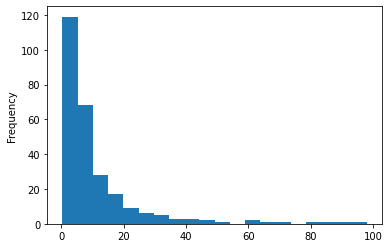

In [256]:
pdTFL_tubes['million'].plot.hist(bins = 20)

In [258]:
pdTFL_tubes.dropna(inplace = True)

In [272]:
del map_LUL

In [273]:
map_LUL = folium.Map(location=[51.51, -0.10], zoom_start=14)

In [274]:
for lat, lng, name, size in zip(pdTFL_tubes['latitude'], pdTFL_tubes['longitude'], pdTFL_tubes['NAME'], pdTFL_tubes['million']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=int(5*np.log(size)), # define how big you want the circle markers to be
        popup = label,
        color='black',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(map_LUL)

map_LUL

### Folium Map of London with Food venues ###

In [281]:
Lon_4sq_venues.groupby('Outcode').count().sort_values('Venue', ascending=False).head(25)

Neighbourhood  latitude  longitude  Venue_id  Venue  Venue_latitude  \
Outcode                                                                        
N1                  93        93         93        93     93              93   
EC1                 86        86         86        86     86              86   
E14                 86        86         86        86     86              86   
SW7                 83        83         83        83     83              83   
N16                 82        82         82        82     82              82   
W4                  78        78         78        78     78              78   
SE1                 76        76         76        76     76              76   
NW1                 74        74         74        74     74              74   
W2                  62        62         62        62     62              62   
N4                  62        62         62        62     62              62   
W5                  61        61         61        61     61              61   
SW1                 59        59         59        59     59              59   
W6                  58        58         58        58     58              58   
SW17                56        56         56        56     56              56   
N22                 55        55         55        55     55              55   
NW10                55        55         55        55     55              55   
SW6                 55        55         55        55     55              55   
SE5                 55        55         55        55     55              55   
E20                 54        54         54        54     54              54   
N8                  54        54         54        54     54              54   
SW19                52        52         52        52     52              52   
SE10                49        49         49        49     49              49   
W12                 48        48         48        48     48              48   
WC2                 47        47         47        47     47              47   
EC2                 47        47         47        47     47              47   

         Venue_longitude  Venue_Postcode  Venue_category  
Outcode                                                   
N1                    93              93              93  
EC1                   86              86              86  
E14                   86              86              86  
SW7                   83              83              83  
N16                   82              82              82  
W4                    78              78              78  
SE1                   76              76              76  
NW1                   74              74              74  
W2                    62              62              62  
N4                    62              62              62  
W5                    61              61              61  
SW1                   59              59              59  
W6                    58              58              58  
SW17                  56              56              56  
N22                   55              55              55  
NW10                  55              55              55  
SW6                   55              55              55  
SE5                   55              55              55  
E20                   54              54              54  
N8                    54              54              54  
SW19                  52              52              52  
SE10                  49              49              49  
W12                   48              48              48  
WC2                   47              47              47  
EC2                   47              47              47

In [285]:
Lon_4sq_venues[100:105]

Outcode Neighbourhood  latitude  longitude                  Venue_id  \
348     E10        Leyton   51.5596    -0.0078  4c3e21e1ca012d7fd60e2fbe   
349     E10        Leyton   51.5596    -0.0078  4c49b0fafbafc9280f8242db   
350     E10        Leyton   51.5596    -0.0078  538b335d498ee7f0fb29018f   
352     E10        Leyton   51.5596    -0.0078  4e52cf1618a85fb6263ad362   
353     E10        Leyton   51.5596    -0.0078  525f01b6498e2c14bf32f9d6   

                               Venue  Venue_latitude  Venue_longitude  \
348                              KFC       51.556158        -0.007545   
349                        Pizza Hut       51.556225        -0.007377   
350                 Albert & Francis       51.563610        -0.005461   
352  Fortune House Chinese Takeaways       51.556813        -0.004919   
353                              BFC       51.554808        -0.005199   

    Venue_Postcode        Venue_category  
348        E10 5NR  Fast Food Restaurant  
349        E10 5NH           Pizza Place  
350            E10                  Café  
352        E10 6QE    Chinese Restaurant  
353            E10   Fried Chicken Joint

In [303]:
Lon_4sq_venues.groupby('Venue_category').count().sort_values('Outcode', ascending=False).head(10)
# Top 10 venue types (categories)

Outcode  Neighbourhood  latitude  longitude  Venue_id  \
Venue_category                                                                
Café                      593            593       593        593       593   
Italian Restaurant        226            226       226        226       226   
Pizza Place               198            198       198        198       198   
Bakery                    180            180       180        180       180   
Indian Restaurant         169            169       169        169       169   
Fast Food Restaurant      143            143       143        143       143   
Sandwich Place            118            118       118        118       118   
Restaurant                118            118       118        118       118   
Turkish Restaurant        110            110       110        110       110   
Chinese Restaurant         98             98        98         98        98   

                      Venue  Venue_latitude  Venue_longitude  Venue_Postcode  
Venue_category                                                                
Café                    593             593              593             593  
Italian Restaurant      226             226              226             226  
Pizza Place             198             198              198             198  
Bakery                  180             180              180             180  
Indian Restaurant       169             169              169             169  
Fast Food Restaurant    143             143              143             143  
Sandwich Place          118             118              118             118  
Restaurant              118             118              118             118  
Turkish Restaurant      110             110              110             110  
Chinese Restaurant       98              98               98              98

In [306]:
!pip3 install xlrd

     |████████████████████████████████| 96 kB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [300]:
pdTemp = Lon_4sq_venues.groupby('Venue_category').count().sort_values('Outcode', ascending=False)
pdTemp.to_csv('Lon_venue_aggr_category.csv')

In [353]:
# Get the raw data into a pd dataframe (and cleanup)
for key in dictConsumerWallet.keys():
    dictConsumerWallet[key].dropna(inplace = True)
    pdTemp = dictConsumerWallet[key][dictConsumerWallet[key]['Sector'] == 'Restaurants and Caffees']
    pdConsumerWallet = pd.concat([pdConsumerWallet, pdTemp], axis = 0)

In [357]:
pdConsumerWallet.to_csv("tempfile.csv")

In [360]:
#tempVector =  pdConsumerWallet['Postcal Code']re.split('(\D+\d+)',item)

pdConsumerWallet['Outcode']=pdConsumerWallet['Postal Code'].str.extract(r'(^\D+\d+)')

In [361]:
pdConsumerWallet.groupby('Outcode').count().sort_values('Sector', ascending=False)

Postal Code  Sector  2021  2022  2023  2024  2025  2026  2027  2028  \
Outcode                                                                        
W1                65      65    65    65    65    65    65    65    65    65   
EC1               31      31    31    31    31    31    31    31    31    31   
EC4               25      25    25    25    25    25    25    25    25    25   
SW1               24      24    24    24    24    24    24    24    24    24   
EC2               23      23    23    23    23    23    23    23    23    23   
...              ...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
N156               1       1     1     1     1     1     1     1     1     1   
N16                1       1     1     1     1     1     1     1     1     1   
N160               1       1     1     1     1     1     1     1     1     1   
N165               1       1     1     1     1     1     1     1     1     1   
NW53               1       1     1     1     1     1     1     1     1     1   

         2029  2030  
Outcode              
W1         65    65  
EC1        31    31  
EC4        25    25  
SW1        24    24  
EC2        23    23  
...       ...   ...  
N156        1     1  
N16         1     1  
N160        1     1  
N165        1     1  
NW53        1     1  

[653 rows x 12 columns]

In [374]:
pdConsumerWallet.head()

Postal Code                   Sector      2021      2022      2023  \
277        EN48  Restaurants and Caffees  5.645637  5.708080  5.762569   
278        EN49  Restaurants and Caffees  4.692449  4.746617  4.795827   
279        EN51  Restaurants and Caffees  4.546466  4.601580  4.651896   
280        EN52  Restaurants and Caffees  5.569179  5.622243  5.669985   
281        EN53  Restaurants and Caffees  1.703791  1.722102  1.738320   

         2024      2025      2026      2027      2028      2029      2030  \
277  5.829934  5.882623  5.945093  6.005013  6.060958  6.124812  6.181022   
278  4.852596  4.899843  4.953323  5.006356  5.051413  5.106980  5.155471   
279  4.708584  4.756317  4.809773  4.863575  4.907531  4.963260  5.011699   
280  5.731596  5.779302  5.837528  5.894163  5.944492  6.004142  6.055296   
281  1.758891  1.774296  1.793482  1.812628  1.828256  1.847635  1.863876   

    Outcode Outcode2  
277     EN4      EN4  
278     EN4      EN4  
279     EN5      EN5  
280     EN5      EN5  
281     EN5      EN5

In [362]:
string = "EN451"

In [364]:
string[:-1]

'EN45'

In [373]:
pdConsumerWallet['Outcode']=pdConsumerWallet['Postal Code'].str[:-1]

In [367]:
pdConsumerWallet.groupby('Outcode2').count().sort_values('Sector', ascending=False)

Postal Code  Sector  2021  2022  2023  2024  2025  2026  2027  2028  \
Outcode2                                                                        
N1                 10      10    10    10    10    10    10    10    10    10   
NW1                10      10    10    10    10    10    10    10    10    10   
NW10               10      10    10    10    10    10    10    10    10    10   
SE1                10      10    10    10    10    10    10    10    10    10   
CR0                10      10    10    10    10    10    10    10    10    10   
...               ...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
TN16                1       1     1     1     1     1     1     1     1     1   
N1C                 1       1     1     1     1     1     1     1     1     1   
IG7                 1       1     1     1     1     1     1     1     1     1   
KT1                 1       1     1     1     1     1     1     1     1     1   
IG5                 1       1     1     1     1     1     1     1     1     1   

          2029  2030  Outcode  
Outcode2                       
N1          10    10       10  
NW1         10    10       10  
NW10        10    10       10  
SE1         10    10       10  
CR0         10    10       10  
...        ...   ...      ...  
TN16         1     1        1  
N1C          1     1        1  
IG7          1     1        1  
KT1          1     1        1  
IG5          1     1        1  

[222 rows x 13 columns]

In [368]:
pdConsumerWallet.groupby('Outcode2').sum()

2021       2022       2023       2024       2025       2026  \
Outcode2                                                                     
BR1       29.963664  30.436119  30.936337  31.433479  31.898118  32.405242   
BR2       26.014898  26.461601  26.931083  27.404574  27.825788  28.304485   
BR3       29.218814  29.730140  30.274533  30.804185  31.302762  31.839827   
BR4       10.647521  10.828869  11.010688  11.211003  11.362588  11.562763   
BR5       19.260301  19.513408  19.788456  20.100300  20.350832  20.673063   
...             ...        ...        ...        ...        ...        ...   
WC2B       2.790651   2.897285   3.009739   3.119640   3.240906   3.362168   
WC2E       1.618823   1.683562   1.750721   1.818466   1.890258   1.963363   
WC2H       5.265852   5.472554   5.689199   5.901350   6.133035   6.366397   
WC2N       1.497346   1.556924   1.618864   1.681437   1.748027   1.815449   
WC2R       0.409097   0.425144   0.441869   0.458848   0.476638   0.495085   

               2027       2028       2029       2030  
Outcode2                                              
BR1       32.920859  33.399445  33.911071  34.427841  
BR2       28.785986  29.226512  29.693539  30.164646  
BR3       32.385471  32.889977  33.423422  33.970109  
BR4       11.758036  11.931785  12.117816  12.297310  
BR5       20.990869  21.287178  21.592694  21.894224  
...             ...        ...        ...        ...  
WC2B       3.483153   3.613422   3.745200   3.883385  
WC2E       2.037085   2.112906   2.193858   2.276912  
WC2H       6.599225   6.847699   7.101561   7.366763  
WC2N       1.883916   1.954094   2.028890   2.105659  
WC2R       0.513649   0.532422   0.552777   0.573471  

[222 rows x 10 columns]

In [371]:
pdPostCodes.head()

Outcode          Neighbourhood  latitude  longitude  Radius
0      E1  E1 Head - Whitechapel   51.5000  -0.061773     900
1      E2          Bethnal Green   51.5500  -0.055525     600
2      E3                    Bow   51.5250  -0.026571    1500
3      E4              Chingford   51.6303   0.000500    2500
4      E5                Clapton   51.5640  -0.054517     600

In [392]:
pdLonPC_conWallet[pdLonPC_conWallet[2030].isna()]

Outcode  2021  2022  2023  2024  2025  2026  2027  2028  2029  2030
18      E20   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
19      EC1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
20      EC2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
21      EC3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
22      EC4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
84      SW1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
104      W1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
118     WC1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
119     WC2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [398]:
missingCodes = pdLonPC_conWallet[pdLonPC_conWallet[2030].isna()].Outcode

In [420]:
missingCodes

18     E20
19     EC1
20     EC2
21     EC3
22     EC4
84     SW1
104     W1
118    WC1
119    WC2
Name: Outcode, dtype: object

In [401]:
pdConsumerWallet_miss = pdConsumerWallet[pdConsumerWallet['Outcode'].str[:-1].isin(missingCodes)]
#drop SW1, W1

In [404]:
pdConsumerWallet_miss

Postal Code                   Sector      2021      2022      2023  \
367       EC1M3  Restaurants and Caffees  0.356919  0.371182  0.386128   
368       EC1N6  Restaurants and Caffees  0.001438  0.001486  0.001537   
369       EC1N7  Restaurants and Caffees  1.881028  1.947607  2.019056   
370       EC1N8  Restaurants and Caffees  1.350784  1.403422  1.458964   
371       EC1R5  Restaurants and Caffees  0.949211  0.986399  1.025666   
..          ...                      ...       ...       ...       ...   
787       WC2N6  Restaurants and Caffees  0.623793  0.649110  0.675338   
788       WC2R0  Restaurants and Caffees  0.224912  0.233892  0.243240   
789       WC2R1  Restaurants and Caffees  0.154933  0.160898  0.167120   
790       WC2R2  Restaurants and Caffees  0.004822  0.004958  0.005112   
791       WC2R3  Restaurants and Caffees  0.024429  0.025396  0.026397   

         2024      2025      2026      2027      2028      2029      2030  \
367  0.400564  0.416397  0.432401  0.448233  0.465292  0.482574  0.500712   
368  0.001588  0.001646  0.001703  0.001760  0.001822  0.001884  0.001948   
369  2.088757  2.166788  2.244719  2.322202  2.406454  2.490295  2.578411   
370  1.512606  1.572248  1.631621  1.691099  1.754941  1.819228  1.886825   
371  1.063517  1.105812  1.147608  1.189782  1.234816  1.280171  1.327884   
..        ...       ...       ...       ...       ...       ...       ...   
787  0.701714  0.729958  0.758230  0.787102  0.816769  0.848219  0.880621   
788  0.252764  0.262546  0.272932  0.283432  0.293650  0.305061  0.316489   
789  0.173404  0.180154  0.186945  0.193739  0.200949  0.208484  0.216293   
790  0.005275  0.005451  0.005637  0.005822  0.006012  0.006218  0.006425   
791  0.027405  0.028487  0.029571  0.030656  0.031811  0.033014  0.034264   

    Outcode Outcode2  
367    EC1M     EC1M  
368    EC1N     EC1N  
369    EC1N     EC1N  
370    EC1N     EC1N  
371    EC1R     EC1R  
..      ...      ...  
787    WC2N     WC2N  
788    WC2R     WC2R  
789    WC2R     WC2R  
790    WC2R     WC2R  
791    WC2R     WC2R  

[293 rows x 14 columns]

In [406]:
pdConsumerWallet_miss['Outcode3'] = pdConsumerWallet_miss['Postal Code'].str[:-1]

<ipython-input-406-e9bcd3f14e01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdConsumerWallet_miss['Outcode3'] = pdConsumerWallet_miss['Postal Code'].str[:-1]


In [407]:
pdConsumerWallet_miss

Postal Code                   Sector      2021      2022      2023  \
367       EC1M3  Restaurants and Caffees  0.356919  0.371182  0.386128   
368       EC1N6  Restaurants and Caffees  0.001438  0.001486  0.001537   
369       EC1N7  Restaurants and Caffees  1.881028  1.947607  2.019056   
370       EC1N8  Restaurants and Caffees  1.350784  1.403422  1.458964   
371       EC1R5  Restaurants and Caffees  0.949211  0.986399  1.025666   
..          ...                      ...       ...       ...       ...   
787       WC2N6  Restaurants and Caffees  0.623793  0.649110  0.675338   
788       WC2R0  Restaurants and Caffees  0.224912  0.233892  0.243240   
789       WC2R1  Restaurants and Caffees  0.154933  0.160898  0.167120   
790       WC2R2  Restaurants and Caffees  0.004822  0.004958  0.005112   
791       WC2R3  Restaurants and Caffees  0.024429  0.025396  0.026397   

         2024      2025      2026      2027      2028      2029      2030  \
367  0.400564  0.416397  0.432401  0.448233  0.465292  0.482574  0.500712   
368  0.001588  0.001646  0.001703  0.001760  0.001822  0.001884  0.001948   
369  2.088757  2.166788  2.244719  2.322202  2.406454  2.490295  2.578411   
370  1.512606  1.572248  1.631621  1.691099  1.754941  1.819228  1.886825   
371  1.063517  1.105812  1.147608  1.189782  1.234816  1.280171  1.327884   
..        ...       ...       ...       ...       ...       ...       ...   
787  0.701714  0.729958  0.758230  0.787102  0.816769  0.848219  0.880621   
788  0.252764  0.262546  0.272932  0.283432  0.293650  0.305061  0.316489   
789  0.173404  0.180154  0.186945  0.193739  0.200949  0.208484  0.216293   
790  0.005275  0.005451  0.005637  0.005822  0.006012  0.006218  0.006425   
791  0.027405  0.028487  0.029571  0.030656  0.031811  0.033014  0.034264   

    Outcode Outcode2 Outcode3  
367    EC1M     EC1M     EC1M  
368    EC1N     EC1N     EC1N  
369    EC1N     EC1N     EC1N  
370    EC1N     EC1N     EC1N  
371    EC1R     EC1R     EC1R  
..      ...      ...      ...  
787    WC2N     WC2N     WC2N  
788    WC2R     WC2R     WC2R  
789    WC2R     WC2R     WC2R  
790    WC2R     WC2R     WC2R  
791    WC2R     WC2R     WC2R  

[293 rows x 15 columns]

In [409]:
pdConsumerWallet_miss.groupby('Outcode').sum()

2021      2022       2023       2024       2025       2026  \
Outcode                                                                   
EC1A     1.513317  1.556270   1.597108   1.661832   1.725717   1.780520   
EC1M     2.266031  2.364294   2.467585   2.571553   2.681820   2.794490   
EC1N     3.238989  3.358394   3.485574   3.609197   3.747156   3.884710   
EC1R     4.710539  4.909427   5.119688   5.331171   5.557894   5.787062   
EC1V     9.429512  9.815997  10.226938  10.647551  11.092814  11.548708   
...           ...       ...        ...        ...        ...        ...   
WC2B     2.790651  2.897285   3.009739   3.119640   3.240906   3.362168   
WC2E     1.618823  1.683562   1.750721   1.818466   1.890258   1.963363   
WC2H     5.265852  5.472554   5.689199   5.901350   6.133035   6.366397   
WC2N     1.497346  1.556924   1.618864   1.681437   1.748027   1.815449   
WC2R     0.409097  0.425144   0.441869   0.458848   0.476638   0.495085   

              2027       2028       2029       2030  
Outcode                                              
EC1A      1.795118   1.860199   1.902623   1.990655  
EC1M      2.911439   3.033181   3.158595   3.291564  
EC1N      4.021769   4.170157   4.318492   4.474583  
EC1R      6.026800   6.275511   6.530690   6.801223  
EC1V     12.025039  12.521883  13.029938  13.569574  
...            ...        ...        ...        ...  
WC2B      3.483153   3.613422   3.745200   3.883385  
WC2E      2.037085   2.112906   2.193858   2.276912  
WC2H      6.599225   6.847699   7.101561   7.366763  
WC2N      1.883916   1.954094   2.028890   2.105659  
WC2R      0.513649   0.532422   0.552777   0.573471  

[72 rows x 10 columns]

In [410]:
pdLonPC_conWallet

Outcode       2021       2022       2023       2024       2025       2026  \
0        E1  51.633002  53.847980  56.191398  58.552910  61.084939  63.682118   
1        E2  31.987029  33.263882  34.613927  35.965629  37.420128  38.899480   
2        E3  36.855938  38.440713  40.115857  41.808827  43.622436  45.482851   
3        E4  20.500222  20.727456  20.890245  21.096303  21.251721  21.458988   
4        E5  17.627337  17.767238  17.923514  18.066452  18.219849  18.352383   
..      ...        ...        ...        ...        ...        ...        ...   
115     W12  48.983157  50.384622  51.899069  53.380817  54.977710  56.473444   
116     W13  24.616057  24.999593  25.377827  25.708226  26.080123  26.406260   
117     W14  46.780594  48.262869  49.840979  51.379661  53.008465  54.577077   
118     WC1        NaN        NaN        NaN        NaN        NaN        NaN   
119     WC2        NaN        NaN        NaN        NaN        NaN        NaN   

          2027       2028       2029       2030  
0    66.397300  69.214491  71.993836  74.907350  
1    40.452845  42.066711  43.658031  45.333632  
2    47.432643  49.457122  51.451845  53.544438  
3    21.653091  21.811157  22.000355  22.201776  
4    18.494089  18.673379  18.824422  19.009010  
..         ...        ...        ...        ...  
115  57.975692  59.587661  61.153483  62.751828  
116  26.737567  27.046728  27.411495  27.777060  
117  56.174593  57.845552  59.505287  61.218789  
118        NaN        NaN        NaN        NaN  
119        NaN        NaN        NaN        NaN  

[120 rows x 11 columns]

In [415]:
pdConsumerWallet_miss.groupby('Outcode').sum()

2021      2022       2023       2024       2025       2026  \
Outcode                                                                   
EC1A     1.513317  1.556270   1.597108   1.661832   1.725717   1.780520   
EC1M     2.266031  2.364294   2.467585   2.571553   2.681820   2.794490   
EC1N     3.238989  3.358394   3.485574   3.609197   3.747156   3.884710   
EC1R     4.710539  4.909427   5.119688   5.331171   5.557894   5.787062   
EC1V     9.429512  9.815997  10.226938  10.647551  11.092814  11.548708   
...           ...       ...        ...        ...        ...        ...   
WC2B     2.790651  2.897285   3.009739   3.119640   3.240906   3.362168   
WC2E     1.618823  1.683562   1.750721   1.818466   1.890258   1.963363   
WC2H     5.265852  5.472554   5.689199   5.901350   6.133035   6.366397   
WC2N     1.497346  1.556924   1.618864   1.681437   1.748027   1.815449   
WC2R     0.409097  0.425144   0.441869   0.458848   0.476638   0.495085   

              2027       2028       2029       2030  
Outcode                                              
EC1A      1.795118   1.860199   1.902623   1.990655  
EC1M      2.911439   3.033181   3.158595   3.291564  
EC1N      4.021769   4.170157   4.318492   4.474583  
EC1R      6.026800   6.275511   6.530690   6.801223  
EC1V     12.025039  12.521883  13.029938  13.569574  
...            ...        ...        ...        ...  
WC2B      3.483153   3.613422   3.745200   3.883385  
WC2E      2.037085   2.112906   2.193858   2.276912  
WC2H      6.599225   6.847699   7.101561   7.366763  
WC2N      1.883916   1.954094   2.028890   2.105659  
WC2R      0.513649   0.532422   0.552777   0.573471  

[72 rows x 10 columns]

In [426]:
pd.merge(pdConsumerWallet_miss.groupby('Outcode').sum(), pdLonPC_conWallet, how='outer').head(30)

2021       2022       2023       2024       2025       2026  \
0    1.513317   1.556270   1.597108   1.661832   1.725717   1.780520   
1    2.266031   2.364294   2.467585   2.571553   2.681820   2.794490   
2    3.238989   3.358394   3.485574   3.609197   3.747156   3.884710   
3    4.710539   4.909427   5.119688   5.331171   5.557894   5.787062   
4    9.429512   9.815997  10.226938  10.647551  11.092814  11.548708   
5    2.368679   2.453036   2.541343   2.642877   2.748532   2.851932   
6    1.630069   1.652402   1.675418   1.695097   1.715657   1.734268   
7    0.242563   0.249415   0.255945   0.266267   0.276497   0.285244   
8    0.021918   0.022538   0.023128   0.024062   0.024985   0.025777   
9    0.040851   0.042012   0.043118   0.044866   0.046587   0.048072   
10   0.047126   0.048453   0.049710   0.051737   0.053690   0.055417   
11   3.787276   3.899727   4.007070   4.172557   4.338641   4.478397   
12   0.107056   0.110091   0.112983   0.117547   0.122067   0.125936   
13   0.043667   0.044906   0.046085   0.047947   0.049790   0.051369   
14   0.685546   0.711213   0.737040   0.768554   0.801029   0.831546   
15   0.274046   0.281780   0.289134   0.300816   0.312330   0.322229   
16   0.036624   0.037663   0.038652   0.040213   0.041760   0.043083   
17   0.545656   0.561252   0.576117   0.599476   0.622673   0.642462   
18   0.374892   0.385775   0.396201   0.412677   0.428302   0.442577   
19   0.044475   0.045749   0.046966   0.048887   0.050757   0.052400   
20   0.045077   0.046358   0.047578   0.049506   0.051406   0.053043   
21   1.113712   1.145936   1.176801   1.225629   1.271956   1.314254   
22   0.409197   0.421143   0.432541   0.450249   0.467965   0.482936   
23  20.475825  21.224008  22.002215  22.775497  23.561893  24.368711   
24  75.539437  76.533620  77.559696  78.513677  79.523120  80.481879   
25  33.758448  34.269484  34.791130  35.276059  35.786879  36.275356   
26  14.545370  14.892593  15.235608  15.576661  15.931028  16.299712   
27  15.306218  15.674888  16.038764  16.399391  16.772938  17.163598   
28  67.012740  67.887118  68.787977  69.643789  70.491217  71.366380   
29  54.645150  55.513370  56.402412  57.271228  58.144658  59.018833   

         2027       2028       2029       2030 Outcode  
0    1.795118   1.860199   1.902623   1.990655     NaN  
1    2.911439   3.033181   3.158595   3.291564     NaN  
2    4.021769   4.170157   4.318492   4.474583     NaN  
3    6.026800   6.275511   6.530690   6.801223     NaN  
4   12.025039  12.521883  13.029938  13.569574     NaN  
5    2.940818   3.056481   3.163276   3.296054     NaN  
6    1.753755   1.774760   1.795498   1.819135     NaN  
7    0.287516   0.297929   0.304699   0.318795     NaN  
8    0.025984   0.026925   0.027537   0.028811     NaN  
9    0.048465   0.050214   0.051363   0.053740     NaN  
10   0.055896   0.057889   0.059218   0.061936     NaN  
11   4.519977   4.685983   4.795752   5.020853     NaN  
12   0.126942   0.131543   0.134538   0.140767     NaN  
13   0.051779   0.053656   0.054877   0.057418     NaN  
14   0.853119   0.887434   0.916333   0.957342     NaN  
15   0.324811   0.336566   0.344215   0.360116     NaN  
16   0.043428   0.045002   0.046026   0.048157     NaN  
17   0.647730   0.671269   0.686627   0.718498     NaN  
18   0.446957   0.462488   0.473547   0.495340     NaN  
19   0.052862   0.054747   0.056020   0.058608     NaN  
20   0.053476   0.055406   0.056674   0.059296     NaN  
21   1.327075   1.373197   1.405938   1.470602     NaN  
22   0.487173   0.504998   0.516699   0.540842     NaN  
23  25.213754  26.089626  26.961606  27.899533    SW10  
24  81.516001  82.466353  83.446351  84.410197    SW11  
25  36.793903  37.273864  37.775564  38.274525    SW12  
26  16.675427  17.036189  17.418248  17.839448    SW13  
27  17.560882  17.940357  18.345411  18.790822    SW14  
28  72.292680  73.088414  73.964864  74.793988    SW15  
29  59.894438  60.773807  61.660159  62.578217    SW16